In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import cv2
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import albumentations as A

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, use_norm=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels) if use_norm else nn.Identity(),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.conv(x)     
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        layers = []
        layers.append(Block(in_channels, features[0], stride=2, use_norm=False))
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        return torch.relu(x + self.block(x))

class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            nn.ReLU(inplace=True)
        )
        
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1)
            ]
        )
        
        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode='reflect')
        
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

In [ ]:
def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    disc = Discriminator(in_channels=3)
    pred = disc(x)
    print(gen(x).shape)
    print(pred.shape)
test()

torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 30, 30])


In [ ]:
transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
    ],
    additional_targets={'image2':'image'},
)

In [ ]:
class MonetDataset(Dataset):
    def __init__(self, images_path, monet_path, transform=None):
        self.root_images = images_path
        self.root_monet = monet_path
        self.transform = transform
        
        self.images = os.listdir(images_path)
        self.monet_pictures = os.listdir(monet_path)
        self.length_dataset = max(len(self.images), len(self.monet_pictures))
        
        self.len_images = len(self.images)
        self.len_monet_pictures = len(self.monet_pictures)
    
    def __len__(self):
        return self.length_dataset
    
    def __getitem__(self, idx):
        image = self.images[idx % self.len_images]
        picture = self.monet_pictures[idx % self.len_monet_pictures]
        
        image_path = os.path.join(self.root_images, image)
        picture_path = os.path.join(self.root_monet, picture)
        
        image = np.array(Image.open(image_path).convert('RGB'))
        picture = np.array(Image.open(picture_path).convert('RGB'))
        if self.transform:
            albumentations = self.transform(image=image, image2=picture)
            image = albumentations['image']
            picture = albumentations['image2']
        return image, picture

In [ ]:
dataset = MonetDataset(images_path='../input/gan-getting-started/photo_jpg',
                       monet_path='../input/gan-getting-started/monet_jpg',
                       transform=transform)

In [ ]:
loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
device = torch.device('cuda:0')

In [ ]:
def save_model(model, optimizer, idx, epoch, name):
    state = {
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
            }
    torch.save(state, f"{name}_{epoch}_{idx}.pth")

In [ ]:
D_I = Discriminator(in_channels=3).to(device)
D_M = Discriminator(in_channels=3).to(device)

G_I = Generator(img_channels=3, num_residuals=5).to(device)
G_M = Generator(img_channels=3, num_residuals=5).to(device)

opt_D = torch.optim.Adam(
    list(D_M.parameters()) + list(D_I.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)
schedule_d = torch.optim.lr_scheduler.StepLR(opt_D, 1, 0.7)

opt_G = torch.optim.Adam(
    list(G_M.parameters()) + list(G_I.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)
schedule_g = torch.optim.lr_scheduler.StepLR(opt_G, 1, 0.7)

l1 = nn.L1Loss()
mse = nn.MSELoss()

In [ ]:
for epoch in range(4):
    for i, (image, picture) in tqdm(enumerate(loader)):
        image = image.transpose(2, 3).transpose(1, 2).float().to(device)
        picture = picture.transpose(2, 3).transpose(1, 2).float().to(device)
        
        fake_image = G_I(picture)
        D_I_real = D_I(image)
        D_I_fake = D_I(fake_image.detach())
        D_I_real_loss = mse(D_I_real, torch.ones_like(D_I_real).to(device))
        D_I_fake_loss = mse(D_I_fake, torch.zeros_like(D_I_fake).to(device))
        D_I_loss = D_I_real_loss + D_I_fake_loss
        
        fake_picture = G_M(image)
        D_M_real = D_M(picture)
        D_M_fake = D_M(fake_picture.detach())
        D_M_real_loss = mse(D_M_real, torch.ones_like(D_M_real).to(device))
        D_M_fake_loss = mse(D_M_fake, torch.zeros_like(D_M_fake).to(device))
        D_M_loss = D_M_real_loss + D_M_fake_loss

        D_loss = (D_M_loss + D_I_loss) / 2

        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()
        
        D_I_fake = D_I(fake_image)
        D_M_fake = D_M(fake_picture)
        G_I_loss = mse(D_I_fake, torch.ones_like(D_I_fake).to(device))
        G_M_loss = mse(D_M_fake, torch.ones_like(D_M_fake).to(device))
        
        
        nephew_image = G_I(fake_picture.detach())
        nephew_picture = G_M(fake_image.detach())
        cycle_loss_M = l1(nephew_picture, picture)
        cycle_loss_I = l1(nephew_image, image)
        identity_loss_I = l1(G_I(image), image)
        identity_loss_M = l1(G_M(picture), picture)
        
        G_Loss = (
                  G_M_loss + 
                  G_I_loss +
                  cycle_loss_M * 10 + 
                  cycle_loss_I * 10 +
                  identity_loss_I +
                  identity_loss_M
                 )
        
        opt_G.zero_grad()
        G_Loss.backward()
        opt_G.step()
        
        if i % 250 == 0:
            print(
                epoch, 
                i, 
                'G_P_loss:', G_I_loss.cpu().detach().item(), 
                'G_M_loss:', G_M_loss.cpu().detach().item(), 
                'D_M_loss:', D_M_loss.cpu().detach().item(), 
                'D_P_loss:', D_I_loss.cpu().detach().item()
            )
        if i % 500 == 0:
            save_image(fake_picture*0.5+0.5, f"/kaggle/working/fakemonet_{epoch}_{i}.png")
            save_image(fake_image*0.5+0.5, f"/kaggle/working/fakeimage_{epoch}_{i}.png")
            save_model(D_I, opt_D, i, epoch, 'd')
            save_model(G_I, opt_G, i, epoch, 'g')
    schedule_d.step()
    schedule_g.step()

0it [00:00, ?it/s]

0 0 G_P_loss: 0.22664859890937805 G_M_loss: 0.37224772572517395 D_M_loss: 0.5263879895210266 D_P_loss: 0.5204454064369202
0 250 G_P_loss: 0.36114832758903503 G_M_loss: 0.4041285216808319 D_M_loss: 0.5059129595756531 D_P_loss: 0.5061861276626587
0 500 G_P_loss: 0.40445995330810547 G_M_loss: 0.47456276416778564 D_M_loss: 0.394977867603302 D_P_loss: 0.4065210223197937
0 750 G_P_loss: 0.30678677558898926 G_M_loss: 0.5535694360733032 D_M_loss: 0.37838059663772583 D_P_loss: 0.4561311602592468
0 1000 G_P_loss: 0.5130833387374878 G_M_loss: 0.4546128213405609 D_M_loss: 0.3403317332267761 D_P_loss: 0.41497498750686646
0 1250 G_P_loss: 0.5674039721488953 G_M_loss: 0.4079091548919678 D_M_loss: 0.34589308500289917 D_P_loss: 0.18565350770950317
0 1500 G_P_loss: 0.5413470268249512 G_M_loss: 0.4547211825847626 D_M_loss: 0.5238972902297974 D_P_loss: 0.2986728847026825
0 1750 G_P_loss: 0.4312969446182251 G_M_loss: 0.3671014606952667 D_M_loss: 0.4745481014251709 D_P_loss: 0.29552459716796875
0 2000 G_P_l

0it [00:00, ?it/s]

1 0 G_P_loss: 0.34860479831695557 G_M_loss: 0.25689125061035156 D_M_loss: 0.548739492893219 D_P_loss: 0.42370203137397766
1 250 G_P_loss: 0.4167051315307617 G_M_loss: 0.2795769274234772 D_M_loss: 0.4847397208213806 D_P_loss: 0.3956628441810608
1 500 G_P_loss: 0.35774049162864685 G_M_loss: 0.269827663898468 D_M_loss: 0.48278993368148804 D_P_loss: 0.354267954826355
1 750 G_P_loss: 0.36335647106170654 G_M_loss: 0.36917951703071594 D_M_loss: 0.5200331807136536 D_P_loss: 0.5319307446479797
1 1000 G_P_loss: 0.332559734582901 G_M_loss: 0.32179689407348633 D_M_loss: 0.5017057657241821 D_P_loss: 0.43715035915374756
1 1250 G_P_loss: 0.37877121567726135 G_M_loss: 0.4671670198440552 D_M_loss: 0.308227002620697 D_P_loss: 0.39664575457572937
1 1500 G_P_loss: 0.2982334494590759 G_M_loss: 0.3855578601360321 D_M_loss: 0.3913170397281647 D_P_loss: 0.4945197105407715
1 1750 G_P_loss: 0.3059341609477997 G_M_loss: 0.3708438277244568 D_M_loss: 0.4091169238090515 D_P_loss: 0.531071662902832
1 2000 G_P_loss: 

0it [00:00, ?it/s]

2 0 G_P_loss: 0.35091254115104675 G_M_loss: 0.43986809253692627 D_M_loss: 0.35748815536499023 D_P_loss: 0.41751033067703247
2 250 G_P_loss: 0.36324724555015564 G_M_loss: 0.3265669643878937 D_M_loss: 0.3974840044975281 D_P_loss: 0.36997896432876587
2 500 G_P_loss: 0.25168538093566895 G_M_loss: 0.3764558434486389 D_M_loss: 0.3982234001159668 D_P_loss: 0.4903402328491211
2 750 G_P_loss: 0.3521375358104706 G_M_loss: 0.3196185231208801 D_M_loss: 0.4818146228790283 D_P_loss: 0.5232069492340088
2 1000 G_P_loss: 0.3067328631877899 G_M_loss: 0.29475438594818115 D_M_loss: 0.5275878310203552 D_P_loss: 0.4640105068683624
2 1250 G_P_loss: 0.29696840047836304 G_M_loss: 0.33732086420059204 D_M_loss: 0.4307151138782501 D_P_loss: 0.43958580493927
2 1500 G_P_loss: 0.3953118324279785 G_M_loss: 0.26611313223838806 D_M_loss: 0.6305059790611267 D_P_loss: 0.3954474925994873
2 1750 G_P_loss: 0.32234668731689453 G_M_loss: 0.29354870319366455 D_M_loss: 0.42693138122558594 D_P_loss: 0.5478298664093018
2 2000 G_P

0it [00:00, ?it/s]

3 0 G_P_loss: 0.45731115341186523 G_M_loss: 0.7506649494171143 D_M_loss: 0.2514822781085968 D_P_loss: 0.5471048951148987
3 250 G_P_loss: 0.4232213795185089 G_M_loss: 0.6538748741149902 D_M_loss: 0.14151623845100403 D_P_loss: 0.36458301544189453
3 500 G_P_loss: 0.30631130933761597 G_M_loss: 0.6168074607849121 D_M_loss: 0.13867945969104767 D_P_loss: 0.49526447057724
3 750 G_P_loss: 0.3172573149204254 G_M_loss: 0.6461437940597534 D_M_loss: 0.1690969318151474 D_P_loss: 0.5348997116088867
3 1000 G_P_loss: 0.3528425991535187 G_M_loss: 0.5800698399543762 D_M_loss: 0.17472518980503082 D_P_loss: 0.3974558115005493
3 1250 G_P_loss: 0.4028747081756592 G_M_loss: 0.5402877330780029 D_M_loss: 0.22692149877548218 D_P_loss: 0.4248887300491333
3 1500 G_P_loss: 0.4376780092716217 G_M_loss: 0.5700952410697937 D_M_loss: 0.3090403378009796 D_P_loss: 0.28486117720603943
3 1750 G_P_loss: 0.3496910035610199 G_M_loss: 0.7742183804512024 D_M_loss: 0.059759628027677536 D_P_loss: 0.48223161697387695
3 2000 G_P_lo

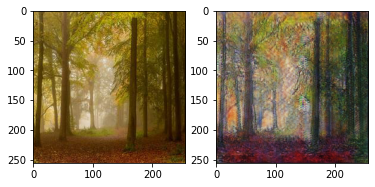

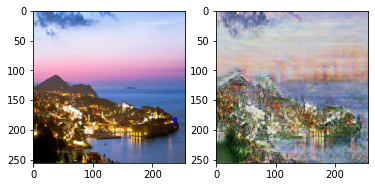

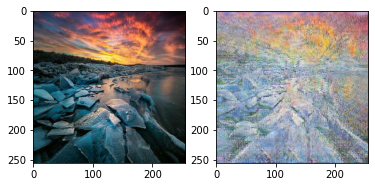

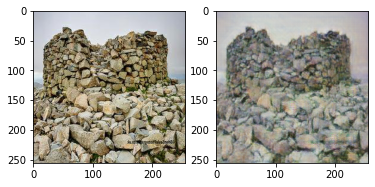

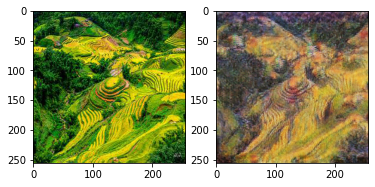

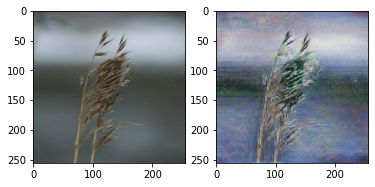

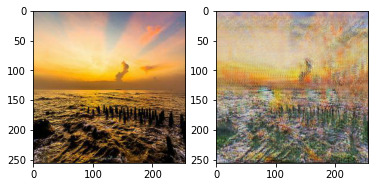

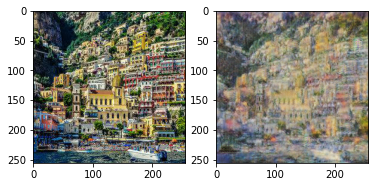

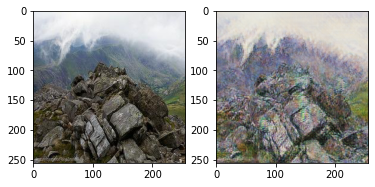

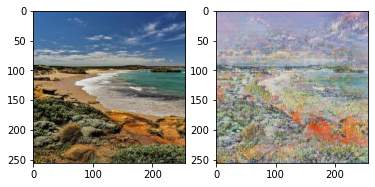

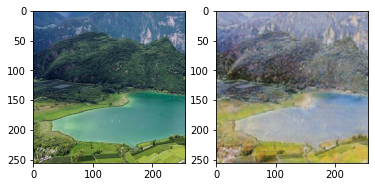

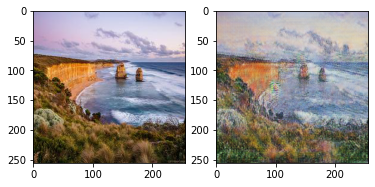

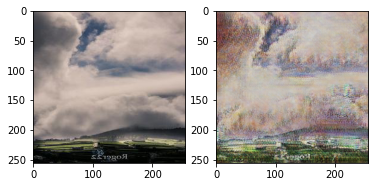

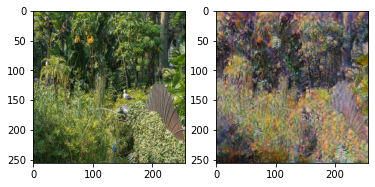

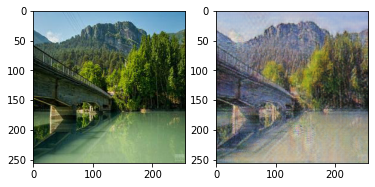

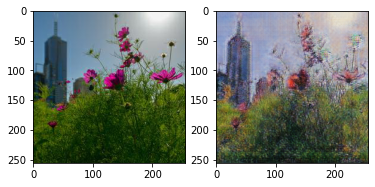

In [ ]:
for idx, (image, _) in enumerate(loader):
    plt.subplot(121)
    plt.imshow(image[0]* 0.5 + 0.5)
    image = image.transpose(2, 3).transpose(1, 2).float().to(device)
    fake_picture = G_M(image).cpu().detach()[0]
    plt.subplot(122)
    plt.imshow(fake_picture.squeeze().permute(1, 2, 0) * 0.5 + 0.5)
    plt.show()
        
    if idx == 15:
        break

In [ ]:
!mkdir /kaggle/working/images

In [ ]:
i = 1
for (image, _) in tqdm(loader):
    pred = G_M(image.transpose(2, 3).transpose(1, 2).float().to(device)).cpu().detach()[0]
    pred = (pred.squeeze().permute(1, 2, 0).numpy() * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(pred)
    im.save("/kaggle/working/images/" + str(i) + ".jpg")
    i += 1

  0%|          | 0/7038 [00:00<?, ?it/s]

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")

'/kaggle/working/images.zip'

In [ ]:
from IPython.display import FileLink
FileLink(r'./images.zip')

/kaggle/working/images.zip

Public score: 50.64292